In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network._base import ACTIVATIONS
import warnings
warnings.filterwarnings('ignore')

In [2]:
VECTOR_SIZE = 1000
TRAIN_TEST_SPLIT = int(VECTOR_SIZE * .7)

class CustomAdaline(object):

    def __init__(self, n_iterations=100, random_state=1, learning_rate=0.01):
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.weights = None
        self.score_ = None

    def fit(self, X: np.array, y: np.array) -> None:
        """
        gets random weights and optimizes them n_iterations times
        :param X: input data to train on
        :param y: input labels to optimize the model with
        :return:
        """
        # use random seed to get initial value for weights
        rgen = np.random.RandomState(self.random_state)
        self.weights = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        # go over the rows applying the weights and optimizing them
        for _ in range(self.n_iterations):
            for row in range(X.shape[0]):
                activation_function_output = self.net_input(X[row])
                error = y[row] - activation_function_output
                self.weights[1:] = self.weights[1:] + self.learning_rate * error
                self.weights[0] = self.weights[0] + self.learning_rate * error
        #print("the weights are: " + str(self.weights))

    def net_input(self, X: np.array) -> np.array:
        """
        apply the weights and bias on the input data
        :param X: input data
        :return: probabilities for possible label
        """
        X_probs = np.dot(X, self.weights[1:]) + self.weights[0]
        return X_probs

    def predict(self, X: np.array) -> np.array:
        """
        predicts labels using fitted algorithm
        :param X: input data
        :return: labels given by algorithm
        """
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [3]:
def deepest_layer(data, MLP, layer=0):
    L = ACTIVATIONS['relu'](np.matmul(data, MLP.coefs_[layer]) + MLP.intercepts_[layer])
    layer += 1
    if layer >= len(MLP.coefs_)-1:
        return L
    else:
        return deepest_layer(L, MLP, layer=layer)
    
def prepare_data(resolution: int, size: int = VECTOR_SIZE, random_state: int = 1, labeling: int = 0) -> np.array:
    """
    create the data with custom query, resolution and size
    :param resolution: the fraction size of the data (100 is 1/100)
    :param size: size of the data
    :param random_state: random seed to use
    :param labeling: if 0 then all data with x > 1/2 & y >1/2 label 1, if 1 then 1/2  <= x**2 + y**2 <= 3/4 label 1
    :return: data using random seed and the query for the labels
    """
    data = np.zeros(shape=(size, 3))
    np.random.seed(random_state)
    data[:, :2] = np.random.randint(-resolution, resolution + 1, size=(size, 2)) / resolution
    # for part A
    if labeling == 0:
        for row in data:
            row[2] = 1 if row[0] > 0.5 and row[1] > 0.5 else -1
    # for part B
    elif labeling == 1:
        for row in data:
            row[2] = 1 if 1 / 2 <= row[0] ** 2 + row[1] ** 2 <= 3 / 4 else -1

    return data

def train_test_split(data: np.ndarray, split: int = TRAIN_TEST_SPLIT)-> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    split the data into X, y with a given train test split ratio
    :param data: the data with features and labels
    :param split: split index
    :return: X_train, X_test, y_train, y_test with the given ratio
    """
    X = data[:, :2]
    y = data[:, 2]

    X_train = X[:split]
    X_test = X[split:]
    y_train = y[:split]
    y_test = y[split:]

    return X_train, X_test, y_train, y_test

In [4]:
def partB(clf, MLP=None, name="progretion"):
    print("Q1: change the labels to be 1 if 1/2  <= x**2 + y**2 <= 3/4")
    VECTOR_SIZE = 1000
    data = prepare_data(resolution=100, size=VECTOR_SIZE, random_state=1, labeling=1)
    X_train, X_test, y_train, y_test = train_test_split(data)
    if MLP is not None:
        X_train = deepest_layer(X_train, MLP)
        X_test = deepest_layer(X_test, MLP)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(score)

    print("Q2: check if adding more data helps")
    plot_progretion(clf, MLP, name)
    
def plot_progretion(clf, MLP=None, name="progretion"):
    scores = np.zeros(10)
    data_size = np.zeros(10)
    for i in range(10):
        data = prepare_data(resolution=100, size=500 * (5 + i), random_state=1, labeling=1)
        X_train, X_test, y_train, y_test = train_test_split(data)
        if MLP is not None:
            X_train = deepest_layer(X_train, MLP)
            X_test = deepest_layer(X_test, MLP)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores[i] = score
        data_size[i] = 500 * (5 + i)

    fig = plt.subplot()
    fig.plot(data_size, scores)
    plt.title(name)
    fig.set_xlabel("data size")
    fig.set_ylabel("accuracy")
    plt.show()


part B
Q1: change the labels to be 1 if 1/2  <= x**2 + y**2 <= 3/4
[[207  31]
 [ 50  12]]
0.73
Q2: check if adding more data helps


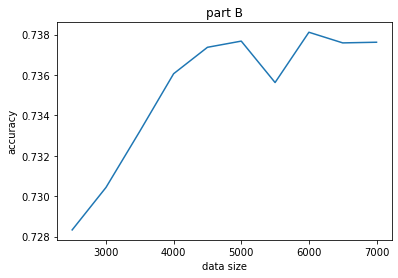

In [5]:
adaline = CustomAdaline(random_state=0)
partB(adaline, name="part B")

Q1: change the labels to be 1 if 1/2  <= x**2 + y**2 <= 3/4
[[220  18]
 [  7  55]]
0.9166666666666666
Q2: check if adding more data helps


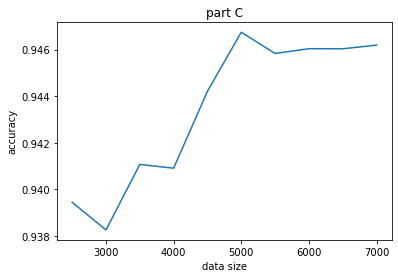

In [6]:
clf = MLPClassifier(hidden_layer_sizes=100, max_iter=1000, alpha=0.2, solver='lbfgs', random_state=0)
partB(clf, name="part C")

Q1: change the labels to be 1 if 1/2  <= x**2 + y**2 <= 3/4
[[238   0]
 [ 62   0]]
0.7933333333333333
Q2: check if adding more data helps


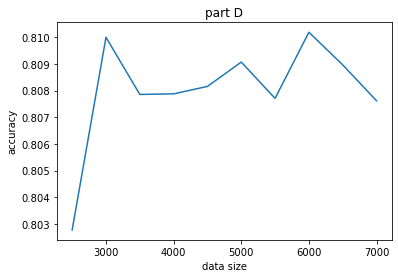

In [11]:
partB(adaline, MLP=clf, name="part D")